In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers, callbacks
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Resizing, BatchNormalization, Lambda, Activation \
    ,Resizing, Rescaling, Dropout, InputLayer, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import os
import glob
import random
import shutil
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import time

In [2]:
IMAGES_DIR = os.path.join(".", "images_labeled")

In [3]:
ground_truth = pd.read_csv("./GroundTruth.csv")
ground_truth.iloc[:, 1:].sum()

MEL      1113.0
NV       6705.0
BCC       514.0
AKIEC     327.0
BKL      1099.0
DF        115.0
VASC      142.0
dtype: float64

In [4]:
import random
p = [x for x in range(10)]
q = random.sample(p, 3)
print(p)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [4]:
data_prep_augmentation = tf.keras.Sequential([
  layers.Resizing(224, 224),
  Lambda(lambda x : tf.image.random_flip_left_right(x)),
  Lambda(lambda x : tf.image.random_flip_up_down(x)),
  Lambda(lambda x : tf.image.random_brightness(x, 0.1, 1.3)),
  Lambda(lambda x : tf.image.random_contrast(x, 0.8, 1.05)),
  Lambda(lambda x : tf.image.random_saturation(x, 0.1, 1.8)),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.15),
])

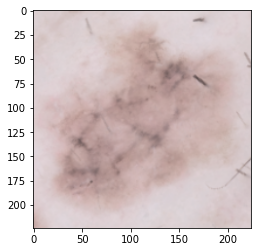

In [110]:
img = Image.open(glob.glob(os.path.join(IMAGES_DIR, "MEL", "MEL*"))[99])
img = np.asarray(img)
plt.imshow(data_prep_augmentation(img).numpy().astype(np.uint8))

In [5]:
os.chdir(IMAGES_DIR)
if os.path.isdir("train") is False:
    os.mkdir("train")
    os.mkdir("valid")
    os.mkdir("test")
    
    for col in ground_truth.iloc[:, 1:].columns:
        print(col)
        os.chdir(col)
        n_img = ground_truth.iloc[:, 1:].sum()[col]
        test_size = int(np.ceil(n_img * .1))
        train_val_size = int(np.floor(n_img * .9))
        train_size = int(np.ceil(train_val_size * .8))
        val_size = int(train_val_size - train_size)

        os.mkdir(os.path.join("..", "train", col))
        os.mkdir(os.path.join("..", "valid", col))
        os.mkdir(os.path.join("..", "test", col))

        idx = np.arange(n_img, dtype=np.int32)
        np.random.shuffle(idx)

        train_file = np.array(glob.glob(col+'*'))[idx[:train_size]]
        val_file = np.array(glob.glob(col+'*'))[idx[train_size:train_val_size]]
        test_file = np.array(glob.glob(col+'*'))[idx[-test_size:]]

        for img in train_file:
            shutil.move(img, os.path.join("..", "train", col))
        for img in val_file:
            shutil.move(img, os.path.join("..", "valid", col))
        for img in test_file:
            shutil.move(img, os.path.join("..", "test", col))

        if n_img < 2000:
            rem_test = 200 - test_size
            rem_train = 1440 - train_size
            rem_val = 360 - val_size
            test_list = glob.glob(os.path.join("..", "test", col, col+'*'))
            train_list = glob.glob(os.path.join("..", "train", col, col+'*'))
            val_list = glob.glob(os.path.join("..", "valid", col, col+'*'))

            for i in range(rem_test):
                rnd = np.random.randint(0, len(test_list))
                img = Image.open(test_list[rnd])
                img = np.asarray(img)
                img = Image.fromarray(data_prep_augmentation(img).numpy().astype(np.uint8))
                img.save(os.path.join("..", "test", col, col+'_test_'+str(i)+".jpg"))

            for i in range(rem_train):
                rnd = np.random.randint(0, len(train_list))
                img = Image.open(train_list[rnd])
                img = np.asarray(img)
                img = Image.fromarray(data_prep_augmentation(img).numpy().astype(np.uint8))
                img.save(os.path.join("..", "train", col, col+'_train_'+str(i)+".jpg"))

            for i in range(rem_val):
                rnd = np.random.randint(0, len(val_list))
                img = Image.open(val_list[rnd])
                img = np.asarray(img)
                img = Image.fromarray(data_prep_augmentation(img).numpy().astype(np.uint8))
                img.save(os.path.join("..", "valid", col, col+'_val_'+str(i)+".jpg"))

        os.chdir("..")
os.chdir("..")


In [6]:
TRAIN_PATH = os.path.join(IMAGES_DIR, "train")
VAL_PATH = os.path.join(IMAGES_DIR, "valid")
TEST_PATH = os.path.join(IMAGES_DIR, "test")

In [7]:
CLASSES = list(ground_truth.iloc[:, 1:].columns)
CLASSES

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [8]:
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    label_mode='categorical',
    batch_size=32,
    image_size=(224,224)
)

val_ds = image_dataset_from_directory(
    VAL_PATH,
    label_mode='categorical',
    batch_size=32,
    image_size=(224,224)
)

Found 13468 files belonging to 7 classes.
Found 3366 files belonging to 7 classes.


In [9]:
train_ds.class_names

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [10]:
total_img = len(glob.glob(os.path.join("images_labeled", "*", "*", "*")))
cl_weight = {}
for i, cl in enumerate(train_ds.class_names):
    cl_weight[i] = total_img / (len(glob.glob(os.path.join("images_labeled", "*", cl, "*"))) * 7)
cl_weight


{0: 1.3360714285714286,
 1: 1.3360714285714286,
 2: 1.3360714285714286,
 3: 1.3360714285714286,
 4: 1.3360714285714286,
 5: 0.3985298817513583,
 6: 1.3360714285714286}

In [11]:
from functools import partial

Conv2D3Kernel = partial(Conv2D, kernel_size=3, strides=1, padding='same', use_bias=False)

In [12]:
def SeResBlock(inputs, filters, strides=1):
    input_main = Conv2D3Kernel(filters, strides=strides)(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = Conv2D3Kernel(filters)(input_main)
    input_main = BatchNormalization()(input_main)

    scaling = GlobalAveragePooling2D()(input_main)
    scaling = Dense(filters/2, activation="relu", kernel_initializer="he_normal")(scaling)
    scaling = BatchNormalization()(scaling)
    scaling = Dense(filters, activation="sigmoid")(scaling)

    input_main = layers.Multiply()([input_main, scaling])

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(input_main + input_skip)

def SeResNextBlock(inputs, filters, strides=1):
    input_main = []
    for i in range(8):
        temp_main = Conv2D3Kernel(12, kernel_size=1)(inputs)
        temp_main = BatchNormalization()(temp_main)
        temp_main = Conv2D3Kernel(12, strides=strides)(temp_main)
        temp_main = BatchNormalization()(temp_main)
        temp_main = Activation(activation=keras.activations.relu)(temp_main)
        temp_main = Conv2D3Kernel(filters, kernel_size=1)(temp_main)
        temp_main = BatchNormalization()(temp_main)
        input_main.append(temp_main)
    
    total_main = input_main[0]
    for item in input_main[1:]:
        total_main = total_main + item

    scaling = GlobalAveragePooling2D()(total_main)
    scaling = Dense(filters/4, activation="relu", kernel_initializer="he_normal")(scaling)
    scaling = BatchNormalization()(scaling)
    scaling = Dense(filters, activation="sigmoid")(scaling)

    total_main = layers.Multiply()([total_main, scaling])
    
    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(total_main + input_skip)

In [13]:
def InvBottleResBlock(inputs, filters, strides=1, ex_r=4):
    input_main = Conv2D3Kernel(filters*ex_r, kernel_size=1, strides=strides)(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = layers.DepthwiseConv2D(kernel_size=3, padding="same", use_bias=False)(input_main)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = Conv2D3Kernel(filters, kernel_size=1)(input_main)

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    elif inputs.shape[3] != filters:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return input_main + input_skip

In [24]:
def InvBotResSeBlock(inputs, filters, strides=1, ex_r=4, kernel=3):
    input_main = Conv2D(filters*ex_r, kernel_size=1, strides=strides, padding='same')(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.swish)(input_main)
    input_main = layers.DepthwiseConv2D(kernel_size=kernel, padding="same", use_bias=False)(input_main)
    input_main = BatchNormalization()(input_main)

    input_se = input_main
    input_se = layers.AveragePooling2D(pool_size=input_se.shape[1])(input_se)
    input_se = Conv2D(filters=filters/2, kernel_size=1, strides=strides, padding='same', activation="swish")(input_se)
    input_se = Conv2D(filters=filters*ex_r, kernel_size=1, strides=strides, padding='same', activation="sigmoid")(input_se)

    input_main = layers.Multiply()([input_main, input_se])

    input_main = Activation(activation=keras.activations.swish)(input_main)
    input_main = Conv2D(filters, kernel_size=1, strides=1, padding='same')(input_main)
    input_main = Dropout(0.3)(input_main)

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    elif inputs.shape[3] != filters:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return input_main + input_skip

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.Input(shape=(224,224,3)),
  Lambda(lambda x : tf.image.random_flip_left_right(x)),
  Lambda(lambda x : tf.image.random_flip_up_down(x)),
  Lambda(lambda x : tf.image.random_brightness(x, 0.8, 1.1)),
  layers.RandomRotation(0.4),
  layers.RandomZoom(0.15),
])

In [16]:
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [18]:
def bin_encode(y, arr):
    y = tf.math.argmax(y, axis=1)
    res = y != y
    for a in arr:
        t = y == a
        res = tf.math.logical_or(res, t)
    
    return tf.one_hot(tf.cast(res, tf.int32), 2)

In [19]:
bin_ds = aug_ds.map(
  lambda x, y: (x, bin_encode(y, [0, 1, 4]))
)

bin_val_ds = val_ds.map(
  lambda x, y: (x, bin_encode(y, [0, 1, 4]))
)

In [22]:
for a in bin_ds.as_numpy_iterator():
    print(a[1])
    break

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [17]:
class DCCELoss(keras.losses.Loss): #DiscouragingCCE
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold
    
    def call(self, y_true, y_pred):
        inv_y_true = tf.cast((y_true == 0) & (y_pred > self.threshold), tf.float32)
        cce = tf.cast(y_true * tf.math.log(y_pred + 1e-7), tf.float32)
        res = inv_y_true * y_pred
        res_entropy = res * tf.math.log(1 - res - 1e-7)
        return tf.reduce_sum(-cce-res_entropy, axis=1)

In [21]:
input_layer = layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(rescaling)
conv_1 = BatchNormalization()(conv_1)
invbot = InvBotResSeBlock(conv_1, 16, ex_r=1)
invbot = InvBotResSeBlock(invbot, 24, 2)
invbot = InvBotResSeBlock(invbot, 24)
invbot = InvBotResSeBlock(invbot, 32, 2, kernel=5)
invbot = InvBotResSeBlock(invbot, 32, kernel=5)
invbot = InvBotResSeBlock(invbot, 64, 2)
invbot = InvBotResSeBlock(invbot, 64)
invbot = InvBotResSeBlock(invbot, 96, kernel=5)
invbot = InvBotResSeBlock(invbot, 128, kernel=5)
invbot = InvBotResSeBlock(invbot, 160, 2, kernel=5)
invbot = InvBotResSeBlock(invbot, 160, kernel=5)

invbot = Conv2D(480, kernel_size=1, strides=1, padding='same')(invbot)
invbot = BatchNormalization()(invbot)
invbot = Activation(activation=keras.activations.swish)(invbot)

global_avg = layers.AveragePooling2D(pool_size=7)(invbot)

conv_2 = Conv2D(filters=240, kernel_size=1, activation="swish")(global_avg)
conv_2 = BatchNormalization()(conv_2)
flatten = Flatten()(conv_2)
output = Dense(7, activation="softmax", name="output")(flatten)
model = Model(inputs=[input_layer], outputs=[output])

model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=3e-4), 
    loss=DCCELoss(), 
    metrics=['accuracy', keras.metrics.CategoricalCrossentropy()]
    )

In [74]:
input_layer = layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(rescaling)
conv_1 = BatchNormalization()(conv_1)
conv_1 = tf.nn.local_response_normalization(conv_1)
invbot = InvBotResSeBlock(conv_1, 16, ex_r=1)
invbot = InvBotResSeBlock(invbot, 24, 2)
invbot = InvBotResSeBlock(invbot, 24)
invbot = InvBotResSeBlock(invbot, 32, 2)
invbot = InvBotResSeBlock(invbot, 32,)
invbot = InvBotResSeBlock(invbot, 64, 2)
invbot = InvBotResSeBlock(invbot, 64)
invbot = InvBotResSeBlock(invbot, 96)
invbot = InvBotResSeBlock(invbot, 96)
invbot = InvBotResSeBlock(invbot, 128)
invbot = InvBotResSeBlock(invbot, 160, 2)
invbot = InvBotResSeBlock(invbot, 160)

invbot = Conv2D(800, kernel_size=1, strides=1, padding='same')(invbot)
invbot = BatchNormalization()(invbot)
invbot = Activation(activation=keras.activations.swish)(invbot)

global_avg = layers.AveragePooling2D(pool_size=7)(invbot)

conv_2 = Conv2D(filters=360, kernel_size=1, activation="swish")(global_avg)
conv_2 = BatchNormalization()(conv_2)
flatten = Flatten()(conv_2)
output = Dense(7, activation="softmax", name="output")(flatten)
model = Model(inputs=[input_layer], outputs=[output])

model.compile(
    optimizer=keras.optimizers.Nadam(), 
    loss=DCCELoss(), 
    metrics=['accuracy', keras.metrics.CategoricalCrossentropy()]
    )

In [22]:
input_layer = layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=5, strides=2, activation="relu", padding="same")(rescaling)
conv_1 = BatchNormalization()(conv_1)
conv_1 = tf.nn.local_response_normalization(conv_1)
invbot = InvBottleResBlock(conv_1, 16, ex_r=1)
invbot = InvBottleResBlock(invbot, 24, 2)
invbot = InvBottleResBlock(invbot, 24)
invbot = InvBottleResBlock(invbot, 32, 2)
invbot = InvBottleResBlock(invbot, 32)
invbot = InvBottleResBlock(invbot, 64, 2)
invbot = InvBottleResBlock(invbot, 64)
invbot = InvBottleResBlock(invbot, 64)
invbot = InvBottleResBlock(invbot, 96)
invbot = InvBottleResBlock(invbot, 96)
invbot = InvBottleResBlock(invbot, 128, 2)
invbot = InvBottleResBlock(invbot, 128)
invbot = InvBottleResBlock(invbot, 200)
conv_2 = Conv2D(filters=360, kernel_size=1, activation="relu")(invbot)
conv_2 = BatchNormalization()(conv_2)
global_avg = GlobalAveragePooling2D()(conv_2)
flatten = Flatten()(global_avg)
output = Dense(7, activation="softmax", name="output")(flatten)
model = Model(inputs=[input_layer], outputs=[output])

model.compile(
    optimizer=keras.optimizers.Nadam(), 
    loss=DCCELoss(), 
    metrics=['accuracy', keras.metrics.CategoricalCrossentropy()]
    )

In [75]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_226 (Conv2D)            (None, 112, 112, 32  896         ['rescaling_4[0][0]']            
                                )                                                                 
                                                                                            

In [29]:
lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.3, patience=1, min_lr=1e-7)

In [30]:
history = model.fit(aug_ds, validation_data=val_ds, epochs=10, class_weight=cl_weight, callbacks=[lr_scheduler])

Epoch 1/10
421/421 [==============================] - 1728s 4s/step - loss: 1.6882 - accuracy: 0.3823 - categorical_crossentropy: 1.5803 - val_loss: 2.9030 - val_accuracy: 0.1173 - val_categorical_crossentropy: 2.9030 - lr: 0.0010
Epoch 2/10
421/421 [==============================] - 1638s 4s/step - loss: 1.4086 - accuracy: 0.4817 - categorical_crossentropy: 1.3058 - val_loss: 1.5706 - val_accuracy: 0.4489 - val_categorical_crossentropy: 1.4793 - lr: 0.0010
Epoch 3/10
421/421 [==============================] - 1806s 4s/step - loss: 1.2804 - accuracy: 0.5376 - categorical_crossentropy: 1.1773 - val_loss: 1.4726 - val_accuracy: 0.5458 - val_categorical_crossentropy: 1.3030 - lr: 0.0010
Epoch 4/10
421/421 [==============================] - 1856s 4s/step - loss: 1.1852 - accuracy: 0.5749 - categorical_crossentropy: 1.0749 - val_loss: 1.4106 - val_accuracy: 0.5597 - val_categorical_crossentropy: 1.2096 - lr: 0.0010
Epoch 5/10
421/421 [==============================] - 1749s 4s/step - loss: 

In [6]:
from keras.models import load_model

model = load_model("skin_cancer_efficentnet_V1_dcceloss.h5", compile=False)
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=1e-5), 
    loss=DCCELoss(), 
    metrics=['accuracy', keras.metrics.CategoricalCrossentropy()]
    )

In [26]:
history2 = model.fit(aug_ds, validation_data=val_ds, epochs=5, class_weight=cl_weight, callbacks=[lr_scheduler])

Epoch 1/5
421/421 [==============================] - 1054s 3s/step - loss: 0.7557 - accuracy: 0.7409 - categorical_crossentropy: 0.6841 - val_loss: 0.9407 - val_accuracy: 0.6884 - val_categorical_crossentropy: 0.8285 - lr: 2.7000e-05
Epoch 2/5
421/421 [==============================] - 1063s 3s/step - loss: 0.7489 - accuracy: 0.7380 - categorical_crossentropy: 0.6800 - val_loss: 0.9661 - val_accuracy: 0.6794 - val_categorical_crossentropy: 0.8466 - lr: 2.7000e-05
Epoch 3/5
421/421 [==============================] - 1064s 3s/step - loss: 0.7505 - accuracy: 0.7426 - categorical_crossentropy: 0.6750 - val_loss: 0.9496 - val_accuracy: 0.6901 - val_categorical_crossentropy: 0.8363 - lr: 8.1000e-06
Epoch 4/5
213/421 [==============>...............] - ETA: 8:18 - loss: 0.7591 - accuracy: 0.7340 - categorical_crossentropy: 0.6863

KeyboardInterrupt: 

In [39]:
history3 = model.fit(aug_ds, validation_data=val_ds, epochs=5, class_weight=cl_weight, callbacks=[lr_scheduler])

Epoch 1/5
421/421 [==============================] - 2158s 5s/step - loss: 0.7819 - accuracy: 0.7292 - categorical_crossentropy: 0.6949 - val_loss: 0.8965 - val_accuracy: 0.7065 - val_categorical_crossentropy: 0.7848 - lr: 2.7000e-05
Epoch 2/5
421/421 [==============================] - 2692s 6s/step - loss: 0.7762 - accuracy: 0.7250 - categorical_crossentropy: 0.6930 - val_loss: 0.9166 - val_accuracy: 0.6970 - val_categorical_crossentropy: 0.7919 - lr: 2.7000e-05
Epoch 3/5
306/421 [====================>.........] - ETA: 8:44 - loss: 0.7836 - accuracy: 0.7254 - categorical_crossentropy: 0.6945

KeyboardInterrupt: 

In [60]:
history4 = model.fit(aug_ds, validation_data=val_ds, epochs=2, class_weight=cl_weight, callbacks=[lr_scheduler])

Epoch 1/2
421/421 [==============================] - 1482s 4s/step - loss: 0.8865 - accuracy: 0.6968 - categorical_crossentropy: 0.7940 - val_loss: 0.9687 - val_accuracy: 0.6797 - val_categorical_crossentropy: 0.8375 - lr: 9.0000e-07
Epoch 2/2
421/421 [==============================] - 1502s 4s/step - loss: 0.8818 - accuracy: 0.7037 - categorical_crossentropy: 0.7877 - val_loss: 0.9692 - val_accuracy: 0.6788 - val_categorical_crossentropy: 0.8380 - lr: 9.0000e-07


In [25]:
input_layer = layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(rescaling)
conv_1 = BatchNormalization()(conv_1)
invbot = InvBotResSeBlock(conv_1, 16, ex_r=1)
invbot = InvBotResSeBlock(invbot, 24, 2)
invbot = InvBotResSeBlock(invbot, 24)
invbot = InvBotResSeBlock(invbot, 32, 2, kernel=5)
invbot = InvBotResSeBlock(invbot, 32, kernel=5)
invbot = InvBotResSeBlock(invbot, 64, 2)
invbot = InvBotResSeBlock(invbot, 64)
invbot = InvBotResSeBlock(invbot, 96, kernel=5)
invbot = InvBotResSeBlock(invbot, 128, 2, kernel=5)
invbot = InvBotResSeBlock(invbot, 128, kernel=5)

invbot = Conv2D(400, kernel_size=1, strides=1, padding='same')(invbot)
invbot = BatchNormalization()(invbot)
invbot = Activation(activation=keras.activations.swish)(invbot)

global_avg = layers.AveragePooling2D(pool_size=7)(invbot)

conv_2 = Conv2D(filters=200, kernel_size=1, activation="swish")(global_avg)
conv_2 = BatchNormalization()(conv_2)
flatten = Flatten()(conv_2)
output = Dense(2, activation="softmax", name="output")(flatten)
bin_model = Model(inputs=[input_layer], outputs=[output])

bin_model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=3e-4), 
    loss="categorical_crossentropy", 
    metrics=['accuracy']
    )

In [26]:
bin_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [48]:
from keras.models import load_model

bin_model = load_model("skin_cancer_bin_V1.h5", compile=False)
bin_model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=1e-6), 
    loss="categorical_crossentropy", 
    metrics=['accuracy', keras.metrics.CategoricalCrossentropy()]
    )

In [54]:
bin_history = bin_model.fit(bin_ds, validation_data=bin_val_ds, epochs=10, callbacks=[lr_scheduler])

Epoch 1/10
421/421 [==============================] - 1219s 3s/step - loss: 0.4233 - accuracy: 0.7911 - categorical_crossentropy: 0.4233 - val_loss: 0.4609 - val_accuracy: 0.7736 - val_categorical_crossentropy: 0.4609 - lr: 1.0000e-06
Epoch 2/10
421/421 [==============================] - 1198s 3s/step - loss: 0.4223 - accuracy: 0.7906 - categorical_crossentropy: 0.4223 - val_loss: 0.4604 - val_accuracy: 0.7736 - val_categorical_crossentropy: 0.4604 - lr: 1.0000e-06
Epoch 3/10
421/421 [==============================] - 1170s 3s/step - loss: 0.4223 - accuracy: 0.7905 - categorical_crossentropy: 0.4223 - val_loss: 0.4605 - val_accuracy: 0.7745 - val_categorical_crossentropy: 0.4605 - lr: 1.0000e-06
Epoch 4/10
336/421 [======================>.......] - ETA: 3:41 - loss: 0.4209 - accuracy: 0.7932 - categorical_crossentropy: 0.4209

KeyboardInterrupt: 

In [73]:
csv_df = pd.DataFrame(history.history)
csv_df.head()
csv_df.to_csv("./skin_cancer_efficientv2_dcceloss.csv")

In [149]:
pd.DataFrame(history.history).head()

,loss,accuracy,categorical_crossentropy,val_loss,val_accuracy,val_categorical_crossentropy,lr
0,1.669235,0.379641,1.594950,2.112214,0.106952,2.112215,0.0003
1,1.403117,0.483516,1.310838,1.742268,0.484551,1.526223,0.0003
2,1.289397,0.535269,1.190240,1.682239,0.479798,1.453151,0.0003
3,1.217812,0.564226,1.117162,1.631845,0.465538,1.470350,0.0003
4,1.155574,0.593704,1.050433,1.287465,0.568925,1.132805,0.0003


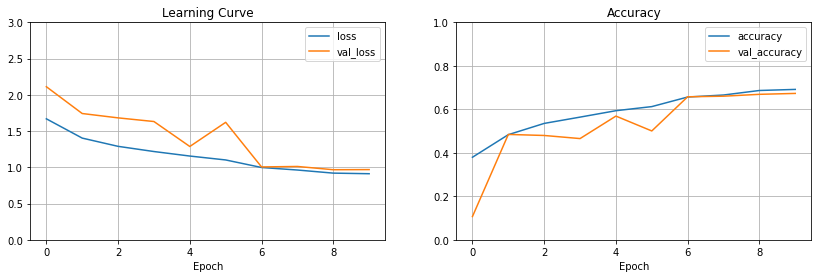

In [150]:


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epoch")
axes[0].grid(True)
axes[0].set_ylim([0,3])

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].set_ylim([0, 1])

plt.show()

(0.0, 1.0)

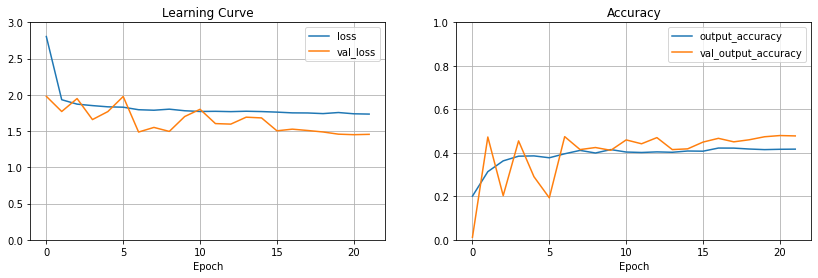

In [ ]:
h1 = pd.DataFrame(history.history)
h2 = pd.DataFrame(history2.history, index=[x for x in range(10, 20)])
h3 = pd.DataFrame(history3.history, index=[20,21])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
pd.concat([h1,h2,h3])[["loss", 'val_loss']].plot(ax=axes[0])
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epoch")
axes[0].grid(True)
axes[0].set_ylim([0,3])

pd.concat([h1,h2,h3])[['output_accuracy', 'val_output_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].set_ylim([0, 1])

(0.0, 1.0)

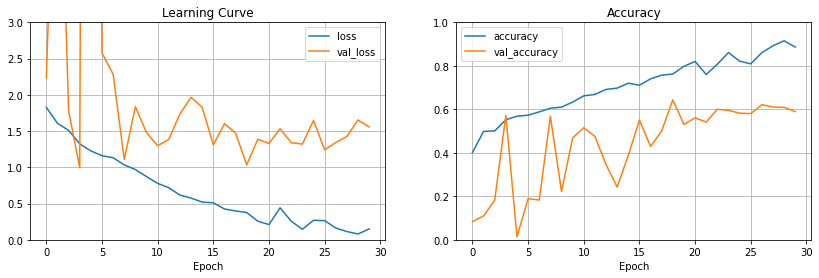

In [ ]:
h1 = pd.DataFrame(history.history)
h2 = pd.DataFrame(history2.history, index=[20, 21])
h3 = pd.DataFrame(history3.history, index=[22, 23])
h4 = pd.DataFrame(history4.history, index=[24, 25,26,27,28,29])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
pd.concat([h1,h2,h3, h4])[["loss", 'val_loss']].plot(ax=axes[0])
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epoch")
axes[0].grid(True)
axes[0].set_ylim([0,3])

pd.concat([h1,h2,h3, h4])[["accuracy", 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].set_ylim([0, 1])

In [ ]:
pd.concat([h1,h2,h3]).tail()

,loss,accuracy,val_loss,val_accuracy
19,0.256554,0.797811,1.388403,0.530458
20,0.209908,0.820293,1.329341,0.560694
21,0.441261,0.760243,1.531931,0.541574
22,0.256901,0.807425,1.340227,0.600267
23,0.145071,0.861115,1.320583,0.595376


In [37]:
model.save("skin_cancer_efficentnet_V2_dcceloss.h5")

In [119]:
bin_model.save("skin_cancer_bin_V1.h5")

In [40]:
test_ds = image_dataset_from_directory(
    TEST_PATH,
    label_mode='categorical',
    batch_size=25,
    image_size=(224,224),
    shuffle=False
)

Found 1871 files belonging to 7 classes.


In [41]:
pred = model.predict(test_ds)
pred

75/75 [==============================] - 66s 877ms/step


array([[2.4548168e-01, 3.6775070e-01, 1.3573788e-01, ..., 8.3569437e-02,
        8.7399278e-03, 5.6153012e-04],
       [2.0505574e-02, 1.7621613e-01, 1.8919615e-01, ..., 4.3800765e-01,
        1.1772591e-01, 8.5295545e-04],
       [5.7171565e-01, 2.7939776e-01, 8.5470572e-02, ..., 5.4110210e-02,
        7.7556623e-03, 4.6195893e-04],
       ...,
       [6.2182359e-03, 8.4769323e-02, 7.6790056e-03, ..., 6.9822087e-03,
        1.1977662e-02, 8.8208991e-01],
       [9.7467437e-06, 5.0649160e-05, 5.0985056e-04, ..., 2.8109322e-03,
        2.8650323e-04, 9.9623704e-01],
       [6.1078228e-02, 7.9165809e-02, 1.5456192e-01, ..., 2.3194467e-01,
        8.4187075e-02, 3.8140744e-01]], dtype=float32)

In [49]:
pred_bin = bin_model.predict(test_ds)
pred_bin

75/75 [==============================] - 63s 793ms/step


array([[0.11325126, 0.8867488 ],
       [0.34220028, 0.6577997 ],
       [0.21693414, 0.78306586],
       ...,
       [0.9579673 , 0.04203276],
       [0.89414   , 0.10586002],
       [0.8125018 , 0.18749824]], dtype=float32)

In [50]:
t = pred_bin
pred_bin = np.divide(np.multiply(pred_bin, pred_bin), np.sum(np.multiply(pred_bin, pred_bin), axis=1).reshape(-1,1))
pred_bin

array([[0.01604938, 0.9839506 ],
       [0.21298783, 0.78701216],
       [0.0712764 , 0.9287236 ],
       ...,
       [0.9980785 , 0.00192149],
       [0.98617685, 0.01382317],
       [0.9494393 , 0.05056068]], dtype=float32)

In [51]:
pred_bin=t

In [52]:
bin_mat = [[0, 0, 1, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0, 0]]
y_bin = np.matmul(pred_bin, bin_mat)
y_bin

array([[0.88674879, 0.88674879, 0.11325126, ..., 0.88674879, 0.11325126,
        0.11325126],
       [0.65779972, 0.65779972, 0.34220028, ..., 0.65779972, 0.34220028,
        0.34220028],
       [0.78306586, 0.78306586, 0.21693414, ..., 0.78306586, 0.21693414,
        0.21693414],
       ...,
       [0.04203276, 0.04203276, 0.95796728, ..., 0.04203276, 0.95796728,
        0.95796728],
       [0.10586002, 0.10586002, 0.89414001, ..., 0.10586002, 0.89414001,
        0.89414001],
       [0.18749824, 0.18749824, 0.81250179, ..., 0.18749824, 0.81250179,
        0.81250179]])

In [53]:
#pred = pred[1]

In [54]:
predmul = np.multiply(pred, y_bin)
predsum = np.sum(predmul, axis=1)
preds = np.divide(predmul, predsum.reshape(-1, 1))

In [55]:
pred[400:420, 2]

array([0.87674046, 0.7225796 , 0.84316015, 0.3006214 , 0.25846004,
       0.40662417, 0.83096206, 0.73338276, 0.682182  , 0.8352147 ,
       0.8017772 , 0.20367464, 0.59967786, 0.2577871 , 0.7733847 ,
       0.28804132, 0.63202107, 0.39487746, 0.07231718, 0.04239139],
      dtype=float32)

In [56]:
preds[400:420, 2]

array([0.91053827, 0.72785845, 0.9511983 , 0.31937264, 0.22530288,
       0.47783593, 0.94707499, 0.91870333, 0.80159494, 0.94863325,
       0.85556949, 0.50167367, 0.72811045, 0.49240543, 0.84972653,
       0.33906984, 0.87117466, 0.39678937, 0.08415324, 0.0450636 ])

In [57]:
y_true = []
for X, y in test_ds:
    for d in y:
        y_true.append(d.numpy())
y_true = np.array(y_true)

In [66]:
y_true_a = np.argmax(y_true, axis=1)
y_pred_a = np.argmax(pred, axis=1)
y_second = np.partition(y_true, -2, axis=1)[:, -2]

In [67]:
y_pred_a

array([1, 4, 0, ..., 6, 6, 6], dtype=int64)

In [68]:
np.sum(preds[np.arange(len(y_pred_a)), y_true_a]) / len(y_pred_a)

0.6536103323325572

In [69]:
y_pred2_a = np.array([(t if f==t or s==t else f) for t, f, s in zip(y_true_a, y_pred_a, y_second)])

In [70]:
y_pred2_a

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

[]

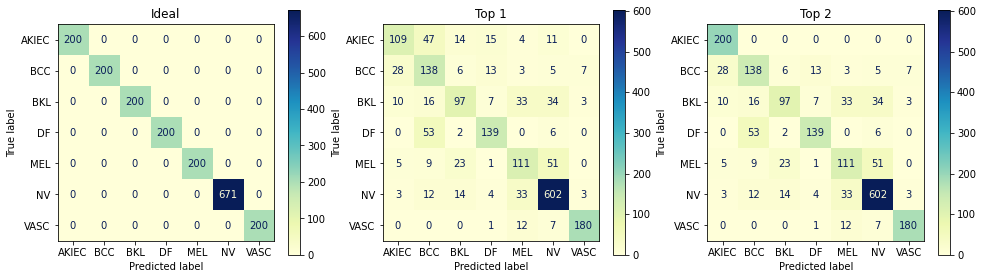

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf = confusion_matrix(y_true_a, y_pred_a)
cf2 = confusion_matrix(y_true_a, y_pred2_a)
ideal = confusion_matrix(y_true_a, y_true_a)

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(16.5, 4.5)
ConfusionMatrixDisplay(ideal, display_labels=train_ds.class_names).plot(cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Ideal")
ConfusionMatrixDisplay(cf, display_labels=train_ds.class_names).plot(cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Top 1")
ConfusionMatrixDisplay(cf2, display_labels=train_ds.class_names).plot(cmap="YlGnBu", ax=axes[2])
axes[2].set_title("Top 2")
plt.plot()



In [72]:
from sklearn.metrics import f1_score, accuracy_score

print("Top 1")
print("Accuracy : ", end="")
print(accuracy_score(y_true_a, y_pred_a))
print("F1 Score : ", end="")
print(f1_score(y_true_a, y_pred_a, average="macro"))
print("")
print("Top 2")
print("Accuracy : ", end="")
print(accuracy_score(y_true_a, y_pred2_a))
print("F1 Score : ", end="")
print(f1_score(y_true_a, y_pred2_a, average="macro"))

Top 1
Accuracy : 0.7354355959380011
F1 Score : 0.6880510090766233

Top 2
Accuracy : 0.7840726884019241
F1 Score : 0.7468533088856184
